# Construcción de una CNN para la Clasificación de la Naturaleza

¡Bienvenido! El mariposario de al lado se ha acercado al jardín botánico con una nueva idea: una aplicación que pueda clasificar no solo flores, sino también insectos y animales pequeños. Tu tarea es diseñar y construir el modelo que hará esto posible.

Este problema es más complejo que lo que has abordado anteriormente. Las capas lineales que utilizaste antes no serán suficientes para capturar los ricos patrones visuales en estas imágenes tan diversas. Para enfrentar este nuevo desafío, construirás una **Red Neuronal Convolucional (CNN)**, un modelo diseñado para reconocer formas, texturas y características en datos visuales.

En este laboratorio, pasarás por el proceso de extremo a extremo de la construcción de una CNN para esta tarea de clasificación. No solo implementarás la arquitectura, sino que también seguirás un flujo de trabajo iterativo —comenzando con un prototipo pequeño antes de escalar— y aprenderás a diagnosticar problemas comunes de entrenamiento.

Tú vas a:

* **Preparar un Dataset Diverso**: Cargar y transformar un subconjunto especializado de imágenes para tu clasificador de naturaleza multiclase.

* **Construir una Arquitectura CNN**: Definir una CNN completa desde cero, combinando capas convolucionales, de agrupación (pooling) y capas totalmente conectadas para crear un extractor de características potente.

* **Entrenar un Modelo de Prototipo**: Seguir un flujo de trabajo realista entrenando primero tu modelo en un subconjunto más pequeño de 9 clases para construir un prototipo funcional y establecer una línea base de rendimiento.

* **Escalar y Diagnosticar Desafíos**: Entrenar el modelo completo con las 15 clases y analizar los resultados para identificar desafíos comunes del aprendizaje automático, como el sobreajuste (overfitting).

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import helper_utils

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Preparación del Dataset de Naturaleza

Para este laboratorio, trabajarás con una colección de imágenes tomadas del conocido [CIFAR-100 dataset](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR100.html). Este conjunto de datos es un recurso fantástico para tareas de visión computacional, ya que contiene miles de pequeñas **imágenes a color de 32x32** que son perfectas para entrenar una CNN. Es una colección diversa, que es exactamente lo que necesitas para la aplicación ampliada de clasificación de la naturaleza.

Aunque CIFAR-100 tiene 100 clases diferentes, no las necesitarás todas. Para cumplir con los nuevos requisitos de tu aplicación, te enfocarás en una selección curada de **15 clases** que se ajustan al tema de un clasificador de naturaleza. Esta selección incluirá flores, insectos y mamíferos. Específicamente, trabajarás con:

* **Flores**: 'orchid', 'poppy', 'rose', 'sunflower', 'tulip'

* **Mamíferos**: 'fox', 'porcupine', 'possum', 'raccoon', 'skunk'

* **Insectos**: 'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'


### Transformaciones de Imagen

Antes de cargar el dataset, primero debes definir los pipelines de transformación para el mismo. Dado que todas las imágenes en el conjunto de datos ya tienen un tamaño estándar de **32x32**, no es necesario añadir un paso de redimensionamiento. Tu pipeline de entrenamiento incluirá aumento de datos (data augmentation), mientras que ambos pipelines convertirán las imágenes en **tensores** y las **normalizarán** utilizando la media y la desviación estándar estándar para el dataset CIFAR-100.

* Define la media y la desviación estándar específicas para el dataset CIFAR-100.

In [3]:
cifar100_mean = (0.5071, 0.4867, 0.4408)
cifar100_std = (0.2675, 0.2565, 0.2761)

* Define dos pipelines separados utilizando `transforms.Compose`.
    * Uno para el conjunto de entrenamiento que incluya aumento de datos (data augmentation) y otro para el conjunto de validación.

In [4]:
# Training set transformation pipeline
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

# Validation set transformation pipeline
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar100_mean, cifar100_std)
])

### Preparación del Pipeline de Datos

Con tus transformaciones listas, es hora de cargar los datos. Para mostrar rápidamente al mariposario de al lado un prototipo funcional, una estrategia inteligente es comenzar con un conjunto de datos más pequeño y manejable. Esto te permite probar todo tu pipeline y construir un modelo base sin los largos tiempos de espera que requiere el conjunto de datos completo.

Por lo tanto, en lugar de utilizar las 15 clases a la vez, comenzarás con un subconjunto equilibrado de **9 clases** (**3 de cada categoría**). Este enfoque iterativo es una práctica común y eficiente en el aprendizaje automático del mundo real.

Para este prototipo inicial, utilizarás las siguientes clases:

* **Flores**: 'orchid', 'poppy', 'sunflower'

* **Mamíferos**: 'fox', 'raccoon', 'skunk'

* **Insectos**: 'butterfly', 'caterpillar', 'cockroach'

* Crea una lista de Python que contenga los nombres de las 9 clases que utilizarás para el prototipo inicial.

In [5]:
subset_target_classes = [
    # Flowers
    'orchid', 'poppy', 'sunflower',
    # Mammals
    'fox', 'raccoon', 'skunk',
    # Insects
    'butterfly', 'caterpillar', 'cockroach'
]

* Usa la función auxiliar `load_cifar100_subset`, pasando tu lista `subset_target_classes` y ambos pipelines de transformación.
* Esta función se encarga de todo el proceso de carga: descarga el dataset CIFAR-100 completo, aplica las transformaciones especificadas y luego filtra el resultado para incluir únicamente las **9 clases** que seleccionaste.
* Devuelve los objetos finales de los datasets de entrenamiento y validación, listos para el siguiente paso.

In [10]:
# Llamar a la función auxiliar para preparar los conjuntos de datos
train_dataset_proto, val_dataset_proto = helper_utils.load_cifar100_subset(subset_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.
Dataset loaded successfully.

Filtering for 9 classes...
Filtering complete. Returning training and validation datasets.


* Con tus objetos `Dataset` listos, el paso final en el pipeline de datos es crear los `DataLoaders`.

In [17]:
# Set the number of samples to be processed in each batch
batch_size = 64

# Create a data loader for the training set, with shuffling enabled
train_loader_proto = DataLoader(train_dataset_proto, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set, without shuffling
val_loader_proto = DataLoader(val_dataset_proto, batch_size=batch_size, shuffle=False)

### Visualización de las Imágenes de Entrenamiento

Con el pipeline de datos completado, siempre es una buena idea observar algunos ejemplos de tu conjunto de entrenamiento. Esto ayuda a confirmar que tus datos se han cargado y procesado correctamente. La siguiente función auxiliar mostrará una muestra aleatoria de tus imágenes de entrenamiento.

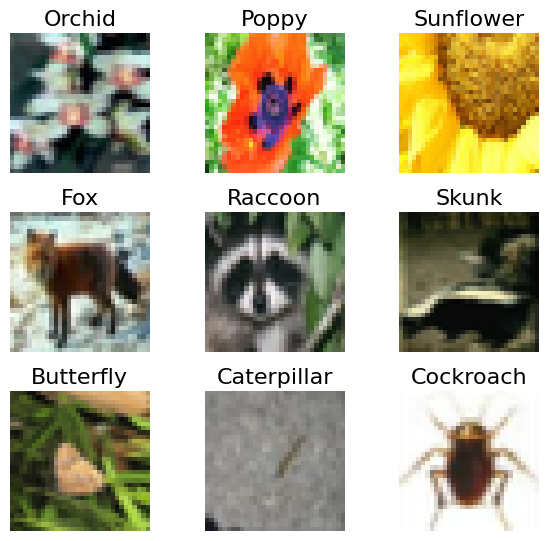

In [18]:
# Visualize a 3x3 grid of random training images
helper_utils.visualise_images(train_dataset_proto, grid=(3, 3))

## Construcción de la Arquitectura CNN

Con tus datos listos, es hora de construir el núcleo de tu clasificador de naturaleza. Para una tarea compleja como identificar diferentes especies en imágenes, las capas lineales que has usado antes no son suficientes, ya que analizan los píxeles individualmente sin entender sus relaciones espaciales.

Ahora construirás una **Red Neuronal Convolucional (CNN)**, una arquitectura diseñada específicamente para "ver" y reconocer patrones, bordes y texturas en imágenes a través de una serie de filtros aprendibles. Definirás la estructura de tu modelo usando `nn.Module` de PyTorch, combinando varios tipos de capas para crear un potente clasificador de imágenes.

Aquí tienes un desglose de las capas clave que utilizarás:



**Capa Convolucional (<code>[nn.Conv2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)</code>)**
> Este es el bloque de construcción fundamental de una CNN, que utiliza filtros aprendibles para escanear la imagen en busca de características visuales. La salida es un conjunto de "mapas de características" (feature maps) que resaltan en qué parte de la imagen aparecen estos patrones.
> * `in_channels`: El número de canales de la capa anterior; para la primera capa, es 3 por los canales de color RGB.
> * `out_channels`: El número de filtros que la capa aprenderá, lo que determina el número de mapas de características de salida.
> * `kernel_size`: Las dimensiones del filtro, como una cuadrícula de 3x3 que examina un píxel y sus vecinos inmediatos.
> * `padding`: Añade un borde alrededor de la imagen, permitiendo que el kernel procese los píxeles de los bordes mientras preserva las dimensiones de la imagen.



**Función de Activación ReLU (<code>[nn.ReLU](https://docs.pytorch.org/docs/stable/generated/torch.nn.ReLU.html)</code>)**
> Una función de activación que introduce no linealidad cambiando todos los valores negativos en los mapas de características a cero. Esto ayuda al modelo a aprender patrones más complejos.

**Capa de Agrupación Máxima (Max Pooling) (<code>[nn.MaxPool2d](https://docs.pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)</code>)**
> Esta capa reduce el muestreo de los mapas de características disminuyendo su altura y anchura, lo que hace que la red sea más eficiente. Desliza una ventana sobre el mapa de características y conserva solo el valor más grande de esa ventana, descartando el resto.
> * `kernel_size`: El tamaño de la ventana sobre la cual realizar la agrupación, como un área de 2x2.
> * `stride`: El tamaño del paso con el que la ventana se mueve a través de la imagen. Un stride de 2 con un kernel de 2x2 reducirá a la mitad las dimensiones del mapa de características.



**Capa de Aplanado (Flatten) (<code>[nn.Flatten](https://docs.pytorch.org/docs/stable/generated/torch.nn.Flatten.html)</code>)**
> Una capa de utilidad que desenrolla los mapas de características 2D en un solo vector 1D. Este es un paso necesario para preparar los datos para las capas lineales totalmente conectadas.

**Capa Lineal (<code>[nn.Linear](https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html)</code>)**
> También conocida como capa totalmente conectada (fully connected), realiza la clasificación final. Combina las características aprendidas por las capas convolucionales en una predicción final.

**Capa de Abandono (Dropout) (<code>[nn.Dropout](https://docs.pytorch.org/docs/stable/generated/torch.nn.Dropout.html)</code>)**
> Una técnica de regularización que ayuda a prevenir el sobreajuste (overfitting) al establecer aleatoriamente una fracción de las activaciones de las neuronas a cero durante el entrenamiento. Esto obliga a la red a aprender características más robustas en lugar de depender demasiado de un solo patrón.

In [19]:
class SimpleCNN(nn.Module):
    """
    Un modelo simple de Red Neuronal Convolucional (CNN).

    La arquitectura consta de tres bloques convolucionales seguidos de dos
    capas totalmente conectadas (fully connected) para la clasificación.
    """
    def __init__(self, num_classes):
        """
        Inicializa las capas de la red neuronal.

        Argumentos:
            num_classes: El número de clases de salida para la capa final.
        """
        # Llamar al constructor de la clase padre (nn.Module)
        super(SimpleCNN, self).__init__()
        
        # Definir el primer bloque convolucional
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Definir el segundo bloque convolucional
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Definir el tercer bloque convolucional
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Definir la capa para aplanar (flatten) los mapas de características
        self.flatten = nn.Flatten()

        # Definir las capas totalmente conectadas (densas)
        # La imagen de entrada es de 32x32, tras 3 capas de pooling: 4x4
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        """
        Define el paso hacia adelante (forward pass) del modelo.

        Argumentos:
            x: El tensor de entrada de forma (batch_size, channels, height, width).

        Retorna:
            El tensor de salida que contiene los logits para cada clase.
        """
        # Pasar la entrada a través del primer bloque convolucional
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Pasar los mapas de características a través del segundo bloque convolucional
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Pasar los mapas de características a través del tercer bloque convolucional
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        # Aplanar la salida para las capas totalmente conectadas
        x = self.flatten(x)

        # Pasar las características aplanadas a través de las capas totalmente conectadas
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Retornar los logits de salida finales
        return x

* Con la arquitectura `SimpleCNN` definida, el siguiente paso es crear una instancia del modelo para tu prototipo.

* Primero, determina dinámicamente el número de clases de salida verificando la longitud de la lista de clases en tu `train_dataset_proto`.
* Crea una instancia de tu `SimpleCNN`, pasando `num_classes` a su constructor.

In [21]:
# Get the number of classes
num_classes = len(train_dataset_proto.classes)
print("Numero de clases: ", num_classes)
# Instantiate the model
prototype_model = SimpleCNN(num_classes)

Numero de clases:  9


Antes de comenzar el entrenamiento, es muy útil visualizar cómo cambia la forma (shape) de tus datos a medida que fluyen a través de la CNN. Esto confirmará que tu arquitectura está configurada correctamente y te mostrará cómo las dimensiones espaciales se reducen mientras el número de canales aumenta con cada bloque convolucional.

* Define la función auxiliar `print_data_flow`. 
    * Esta función pasará una imagen a color de muestra de 32x32 a través de tu modelo, capa por capa, imprimiendo la forma del tensor en cada paso clave para rastrear su trayecto desde la entrada hasta la predicción final.

In [22]:
def print_data_flow(model):
    """
    Imprime la forma (shape) de un tensor a medida que fluye por cada capa del modelo.

    Args:
        model: Una instancia del modelo PyTorch para inspeccionar.
    """
    # Crear un tensor de entrada de muestra (tamaño_lote, canales, altura, ancho)
    x = torch.randn(1, 3, 32, 32)

    # Rastrear la forma del tensor en cada etapa
    print(f"Forma de entrada: \t\t{x.shape}")

    # Primer bloque convolucional
    x = model.conv1(x)
    print(f"Después de conv1: \t\t{x.shape}")
    x = model.relu1(x)
    x = model.pool1(x)
    print(f"Después de pool1: \t\t{x.shape}")

    # Segundo bloque convolucional
    x = model.conv2(x)
    print(f"Después de conv2: \t\t{x.shape}")
    x = model.relu2(x)
    x = model.pool2(x)
    print(f"Después de pool2: \t\t{x.shape}")

    # Tercer bloque convolucional
    x = model.conv3(x)
    print(f"Después de conv3: \t\t{x.shape}")
    x = model.relu3(x)
    x = model.pool3(x)
    print(f"Después de pool3: \t\t{x.shape}")

    # Aplanar usando la capa flatten del modelo
    x = model.flatten(x)
    print(f"Después de flatten: \t\t{x.shape}")

    # Capas totalmente conectadas (FC)
    x = model.fc1(x)
    print(f"Después de fc1: \t\t{x.shape}")
    x = model.relu4(x)
    x = model.dropout(x)
    x = model.fc2(x)
    print(f"Forma de salida (fc2): \t{x.shape}")

Ahora puedes imprimir un resumen de tu modelo y rastrear el flujo de datos para verlo en acción.

* Llama a tu función auxiliar para imprimir la forma (shape) del tensor en cada paso.

    * El tensor comienza como una imagen de `(1, 3, 32, 32)`. A medida que pasa por los bloques `conv` y `pool`, el número de **canales aumenta** mientras que el **tamaño espacial se reduce a la mitad** en cada paso.

    * El mapa de características final de `(1, 128, 4, 4)` se **aplana** (flatten) en un vector 1D para ser procesado por las capas lineales. La **forma de salida final** del modelo es `(1, 9)`, proporcionando una puntuación para cada una de las 9 clases.

In [23]:
# Print the model's architecture
print(prototype_model)

# Call the helper function to visualize the data flow
print("\n--- Tracing Data Flow ---")
print_data_flow(prototype_model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)

--- Tracing Data Flow ---
Forma de entrada: 		torch.Size([1, 3, 32, 32])
Después de conv1: 		torch.Size([1, 32, 32, 32])
Después de pool1: 		torch.Size([1, 32, 16, 16])
Después de conv2: 		torch.Size([1, 64, 16, 1

## Entrenamiento del Modelo

Con tu modelo definido y el pipeline de datos preparado, estás listo para configurar el proceso de entrenamiento. Esto implica inicializar una función de pérdida (loss function) para medir el error de tu modelo y un optimizador para actualizar sus pesos basándose en ese error.

### Inicializar la Función de Pérdida y el Optimizador

Antes de comenzar el bucle de entrenamiento, definirás dos componentes clave:

* Usarás <code>[nn.CrossEntropyLoss](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)</code>. Esta es la función de pérdida estándar para tareas de clasificación multiclase, ya que está diseñada para medir el error cuando un modelo debe elegir una clase entre varias posibilidades.
* Usarás el optimizador <code>[Adam](https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html)</code>. Este es un algoritmo popular y eficiente que actualiza los pesos del modelo para minimizar la pérdida.

In [24]:
# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimizer for the prototype model
optimizer_prototype = optim.Adam(prototype_model.parameters(), lr=0.001)

### El Bucle de Entrenamiento

* A continuación, definirás la función `training_loop`. Esta función encapsula todo el proceso de entrenamiento y validación de tu modelo a lo largo de múltiples épocas (epochs).

In [33]:
def training_loop(model, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
    """
    Entrena y valida un modelo de red neuronal en PyTorch.

    Args:
        model: El modelo de red neuronal a entrenar.
        train_loader: DataLoader para el conjunto de datos de entrenamiento.
        val_loader: DataLoader para el conjunto de datos de validación.
        loss_function: La función de pérdida a utilizar para el entrenamiento.
        optimizer: El algoritmo de optimización.
        num_epochs: El número total de épocas para el entrenamiento.
        device: El dispositivo (ej. 'cpu' o 'cuda') donde se ejecutará el entrenamiento.

    Returns:
        Una tupla que contiene:
        - El modelo entrenado.
        - Una lista de métricas [train_losses, val_losses, val_accuracies].
    """
    # Mover el modelo al dispositivo especificado (CPU o GPU)
    model.to(device)
    
    # Inicializar listas para almacenar las métricas de entrenamiento y validación
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    # Imprimir un mensaje indicando el inicio del proceso de entrenamiento
    print("--- Entrenamiento Iniciado ---")
    
    # Bucle sobre el número especificado de épocas
    for epoch in range(num_epochs):
        # Establecer el modelo en modo de entrenamiento
        model.train()
        # Inicializar la pérdida acumulada para la época actual
        running_loss = 0.0
        # Iterar sobre los lotes de datos en el cargador de entrenamiento
        for images, labels in train_loader:
            # Mover imágenes y etiquetas al dispositivo especificado
            images, labels = images.to(device), labels.to(device)
            
            # Limpiar los gradientes de todas las variables optimizadas
            optimizer.zero_grad()
            # Realizar un paso hacia adelante (forward pass) para obtener las salidas del modelo
            outputs = model(images)
            # Calcular la pérdida
            loss = loss_function(outputs, labels)
            # Realizar un paso hacia atrás (backward pass) para calcular los gradientes
            loss.backward()
            # Actualizar los parámetros del modelo
            optimizer.step()
            
            # Acumular la pérdida de entrenamiento para el lote
            running_loss += loss.item() * images.size(0)

        # Calcular el promedio de la pérdida de entrenamiento para la época
        epoch_loss = running_loss / len(train_loader.dataset)
        # Añadir la pérdida de la época a la lista de pérdidas de entrenamiento
        train_losses.append(epoch_loss)
        
        # Establecer el modelo en modo de evaluación
        model.eval()
        # Inicializar la pérdida de validación acumulada y el conteo de predicciones correctas
        running_val_loss = 0.0
        correct = 0
        total = 0
        # Desactivar el cálculo de gradientes para la validación
        with torch.no_grad():
            # Iterar sobre los lotes de datos en el cargador de validación
            for images, labels in val_loader:
                # Mover imágenes y etiquetas al dispositivo especificado
                images, labels = images.to(device), labels.to(device)
                
                # Realizar un paso hacia adelante para obtener las salidas del modelo
                outputs = model(images)
                
                # Calcular la pérdida de validación para el lote
                val_loss = loss_function(outputs, labels)
                # Acumular la pérdida de validación
                running_val_loss += val_loss.item() * images.size(0)
                
                # Obtener las etiquetas de las clases predichas
                _, predicted = torch.max(outputs, 1)
                # Actualizar el número total de muestras
                total += labels.size(0)
                # Actualizar el número de predicciones correctas
                correct += (predicted == labels).sum().item()
                
        # Calcular el promedio de la pérdida de validación para la época
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        # Añadir la pérdida de validación de la época a la lista
        val_losses.append(epoch_val_loss)
        
        # Calcular la precisión de validación para la época
        epoch_accuracy = 100.0 * correct / total
        # Añadir la precisión de la época a la lista
        val_accuracies.append(epoch_accuracy)
        
        # Imprimir las métricas para la época actual
        print(f"Época [{epoch+1}/{num_epochs}], Pérdida Train: {epoch_loss:.4f}, Pérdida Val: {epoch_val_loss:.4f}, Precisión Val: {epoch_accuracy:.2f}%")
        
    # Imprimir un mensaje indicando el fin del proceso de entrenamiento
    print("--- Entrenamiento Finalizado ---")
    
    # Consolidar todas las métricas en una sola lista
    metrics = [train_losses, val_losses, val_accuracies]
    
    # Devolver el modelo entrenado y las métricas recolectadas
    return model, metrics

Con todos los componentes en su lugar, estás listo para comenzar el entrenamiento.

* Ejecuta la función `training_loop` con tu modelo de prototipo (para 9 clases), sus cargadores de datos correspondientes, la función de pérdida y el optimizador. 
* Entrenarás durante `15 épocas` (epochs), y la función devolverá el modelo entrenado junto con las métricas de rendimiento recolectadas.
* Una vez completado el entrenamiento, utilizarás la función auxiliar `plot_training_metrics` para visualizar la pérdida (loss) de entrenamiento y validación, junto con la precisión (accuracy) de validación.

--- Entrenamiento Iniciado ---
Época [1/15], Pérdida Train: 1.6623, Pérdida Val: 1.2959, Precisión Val: 53.33%
Época [2/15], Pérdida Train: 1.2574, Pérdida Val: 1.1139, Precisión Val: 60.89%
Época [3/15], Pérdida Train: 1.0801, Pérdida Val: 0.9970, Precisión Val: 65.78%
Época [4/15], Pérdida Train: 0.9808, Pérdida Val: 0.9204, Precisión Val: 68.11%
Época [5/15], Pérdida Train: 0.9188, Pérdida Val: 0.8792, Precisión Val: 67.89%
Época [6/15], Pérdida Train: 0.8350, Pérdida Val: 0.8018, Precisión Val: 73.56%
Época [7/15], Pérdida Train: 0.7587, Pérdida Val: 0.8667, Precisión Val: 70.33%
Época [8/15], Pérdida Train: 0.7218, Pérdida Val: 0.7768, Precisión Val: 73.22%
Época [9/15], Pérdida Train: 0.6761, Pérdida Val: 0.7008, Precisión Val: 77.00%
Época [10/15], Pérdida Train: 0.6237, Pérdida Val: 0.7052, Precisión Val: 77.00%
Época [11/15], Pérdida Train: 0.6004, Pérdida Val: 0.6995, Precisión Val: 76.00%
Época [12/15], Pérdida Train: 0.5537, Pérdida Val: 0.6821, Precisión Val: 77.78%
Época 

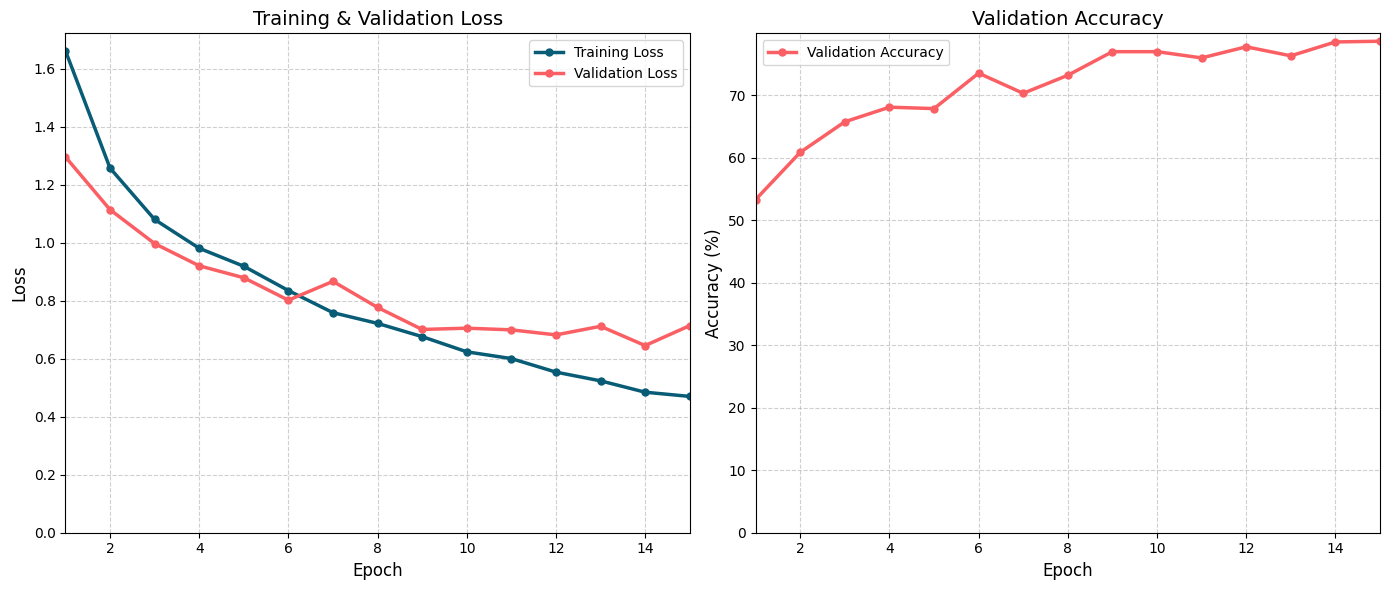

In [34]:
# Iniciar el proceso de entrenamiento llamando a la función del bucle de entrenamiento
trained_proto_model, training_metrics_proto = training_loop(
    model=prototype_model, 
    train_loader=train_loader_proto, 
    val_loader=val_loader_proto, 
    loss_function=loss_function, 
    optimizer=optimizer_prototype, 
    num_epochs=15, 
    device=device
)

# Visualizar las métricas de entrenamiento (pérdida y precisión)
print("\n--- Gráficos de Entrenamiento ---\n")
helper_utils.plot_training_metrics(training_metrics_proto)

<br>

¡Excelente trabajo! El modelo de prototipo está entrenado y los resultados se ven muy prometedores. Lograr una precisión de validación superior al **75%** en el subconjunto de 9 clases es un gran resultado y confirma que tu arquitectura CNN es adecuada para esta tarea.

Este prototipo exitoso te da luz verde para avanzar con la siguiente fase: entrenar un modelo a escala completa con las 15 clases para el mariposario. Pero antes de hacerlo, es útil realizar una última comprobación cualitativa para ver cómo "piensa" tu modelo.

### Visualización de Predicciones

Aunque los gráficos muestran el rendimiento general de tu modelo, observar predicciones individuales proporciona una sensación más intuitiva de sus fortalezas y debilidades. Ahora puedes usar una función auxiliar para ver tu modelo en acción, visualizando sus predicciones en imágenes aleatorias del conjunto de validación. Esto te mostrará ejemplos concretos de dónde tiene éxito y dónde podría estar cometiendo errores.

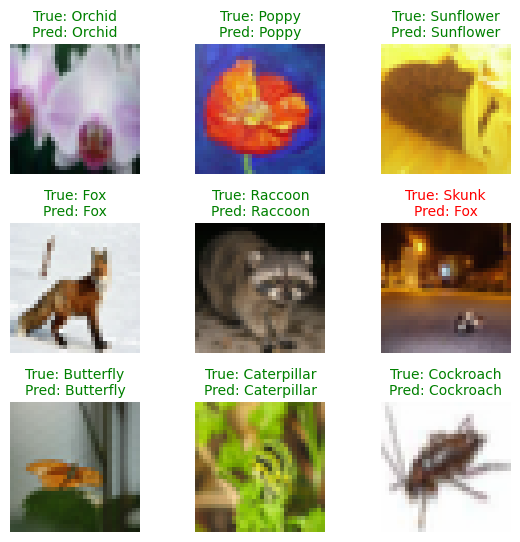

In [35]:
# Visualizar las predicciones del modelo en una muestra de imágenes de validación
helper_utils.visualise_predictions(
    model=trained_proto_model, 
    data_loader=val_loader_proto, 
    device=device, 
    grid=(3, 3)
)

## Escalando: Entrenando el Modelo Completo 

¡El prototipo fue un éxito! Ahora es momento de entrenar el modelo final para la aplicación del mariposario. Repetirás los mismos pasos que antes, pero esta vez utilizando el dataset completo de **15 clases**, el cual es más desafiante.

* Primero, crea una nueva lista que contenga las 15 clases objetivo.
* Utiliza nuevamente la función auxiliar `load_cifar100_subset` para crear los nuevos conjuntos de datos de entrenamiento y validación basados en esta lista completa.

In [36]:
# Define the full class list.
all_target_classes = [
    # Flowers
    'orchid', 'poppy', 'rose', 'sunflower', 'tulip',
    # Mammals
    'fox', 'porcupine', 'possum', 'raccoon', 'skunk',
    # Insects
    'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
]

# Load the full datasets.
train_dataset, val_dataset = helper_utils.load_cifar100_subset(all_target_classes, train_transform, val_transform)

Dataset found in './cifar_100'. Loading from local files.


/home/keras/wordspaces/Pytorch-for-Deep-Learning/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Dataset loaded successfully.

Filtering for 15 classes...
Filtering complete. Returning training and validation datasets.


<br>

* Envuelve tus nuevos datasets de 15 clases en instancias de `DataLoader`, utilizando el mismo `batch_size=64`.

In [37]:
# Create a data loader for the training set, with shuffling enabled
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a data loader for the validation set, without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

* Muestra una muestra de imágenes de tu nuevo conjunto de entrenamiento de 15 clases para confirmar que se ha cargado correctamente.

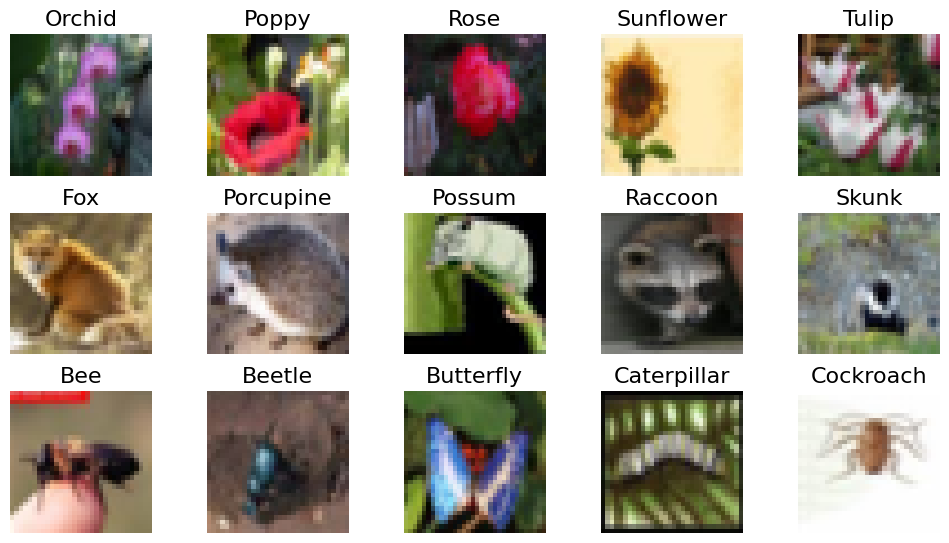

In [38]:
# Visualize a 3x5 grid of random training images
helper_utils.visualise_images(train_dataset, grid=(3, 5))

<br>

* Crea una nueva instancia de tu modelo `SimpleCNN`, esta vez configurado para las **15 clases** en su totalidad.

In [39]:
# Get the number of classes
num_classes = len(train_dataset.classes)

# Instantiate the full model
model = SimpleCNN(num_classes)

# Print the model's architecture (notice, it now has 15 output classes)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)


<br>

* Crea un nuevo optimizador `Adam` para tu modelo completo de 15 clases.

In [40]:
# Optimizer for the full model
optimizer = optim.Adam(model.parameters(), lr=0.001)

* Llama al `training_loop` para entrenar tu modelo de 15 clases durante `25 épocas` (epochs). La función `plot_training_metrics` visualizará inmediatamente después las curvas de pérdida y precisión de esta ejecución de entrenamiento final.

--- Entrenamiento Iniciado ---
Época [1/25], Pérdida Train: 2.1780, Pérdida Val: 1.8029, Precisión Val: 38.07%
Época [2/25], Pérdida Train: 1.8004, Pérdida Val: 1.6075, Precisión Val: 47.27%
Época [3/25], Pérdida Train: 1.6183, Pérdida Val: 1.4712, Precisión Val: 52.07%
Época [4/25], Pérdida Train: 1.4995, Pérdida Val: 1.4159, Precisión Val: 53.93%
Época [5/25], Pérdida Train: 1.3994, Pérdida Val: 1.2806, Precisión Val: 56.93%
Época [6/25], Pérdida Train: 1.3193, Pérdida Val: 1.2781, Precisión Val: 58.67%
Época [7/25], Pérdida Train: 1.2537, Pérdida Val: 1.2024, Precisión Val: 61.07%
Época [8/25], Pérdida Train: 1.1751, Pérdida Val: 1.1281, Precisión Val: 61.80%
Época [9/25], Pérdida Train: 1.1137, Pérdida Val: 1.1090, Precisión Val: 63.80%
Época [10/25], Pérdida Train: 1.0684, Pérdida Val: 1.1657, Precisión Val: 64.47%
Época [11/25], Pérdida Train: 1.0558, Pérdida Val: 1.0990, Precisión Val: 64.80%
Época [12/25], Pérdida Train: 0.9637, Pérdida Val: 1.0722, Precisión Val: 65.07%
Época 

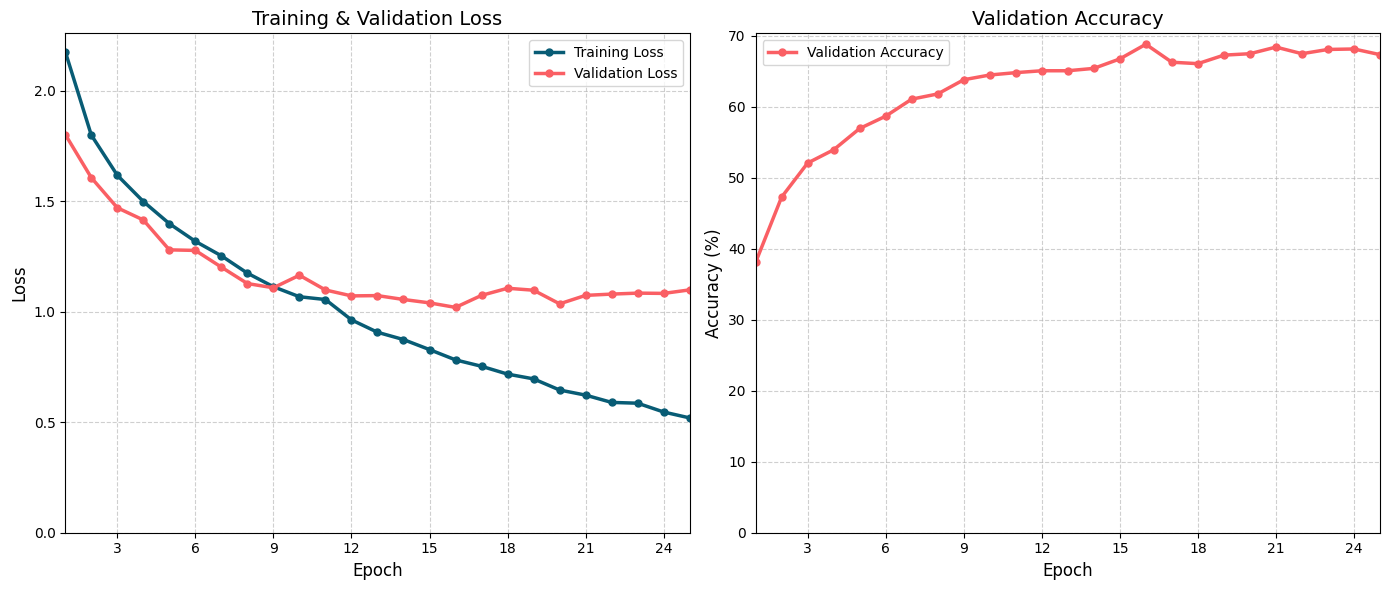

In [41]:
# Iniciar el proceso de entrenamiento para el modelo completo con las 15 clases
trained_model, training_metrics = training_loop(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    loss_function=loss_function, 
    optimizer=optimizer, 
    num_epochs=25, 
    device=device
)

# Visualizar las métricas de entrenamiento para el modelo completo
print("\n--- Gráficos de Entrenamiento ---\n")
helper_utils.plot_training_metrics(training_metrics)

<br>

Después de entrenar el modelo completo, puedes analizar los resultados. Pero espera, algo no está bien aquí. Tu modelo de prototipo se entrenó con éxito, mostrando una mejora constante. Sin embargo, el rendimiento en el dataset completo de 15 clases parece haberse estancado. ¿Qué sucedió?

Una mirada cercana a los gráficos revela el problema. Mientras que la **Pérdida de Entrenamiento (Training Loss)** disminuye constantemente, la **Pérdida de Validación (Validation Loss)** baja por un tiempo y luego comienza a subir y fluctuar. Al mismo tiempo, la **Precisión de Validación (Validation Accuracy)** se queda atascada, llegando a un estancamiento (plateau) sin lograr más progresos significativos. Este es un caso clásico de **sobreajuste (overfitting)**.

El sobreajuste ocurre cuando un modelo aprende los datos de entrenamiento *demasiado bien*, incluyendo su ruido y peculiaridades específicas, en lugar de los patrones generales y subyacentes que le ayudarían a desempeñarse con datos nuevos y no vistos. La brecha cada vez mayor entre la pérdida de entrenamiento y la de validación es una señal clara de que tu modelo está memorizando el conjunto de entrenamiento en lugar de aprender a **generalizar**.

Podrías preguntarte por qué esto sucedió ahora y no con el prototipo de 9 clases. La razón es el aumento significativo en la **complejidad de la tarea**. Distinguir entre 15 clases es mucho más difícil que entre 9, lo que requiere que el modelo aprenda características más sutiles. Ante este desafío más difícil, tu potente modelo CNN encontró un camino más fácil para reducir la pérdida de entrenamiento: comenzó a memorizar los datos en lugar de aprender a generalizar.

Este problema de sobreajuste presenta un desafío realista, similar a lo que encontrarías en un proyecto del mundo real. En la tarea calificada de este módulo, abordarás este problema realizando varias actualizaciones en todo tu pipeline para ver si puedes mejorar la capacidad del modelo para generalizar.

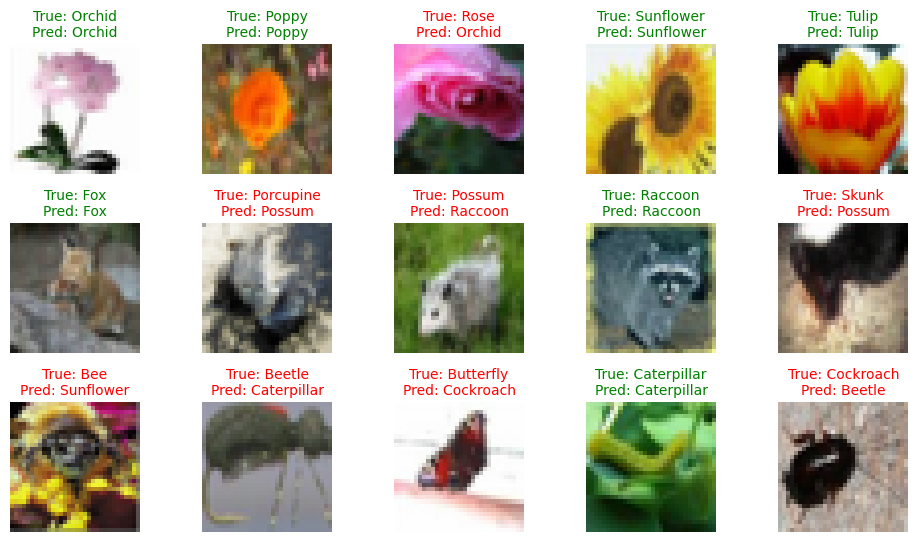

In [42]:
# Opcional: Descomenta y ejecuta esta celda para ver las predicciones realizadas por el modelo completo
helper_utils.visualise_predictions(
     model=trained_model, 
     data_loader=val_loader, 
     device=device, 
     grid=(3, 5)
 )

## Conclusión

¡Felicitaciones por completar el laboratorio! Has navegado con éxito por todo el pipeline de aprendizaje automático, desde la preparación de los datos hasta la construcción, el entrenamiento y el análisis de tu propia Red Neuronal Convolucional.

Has puesto la teoría en práctica al construir una arquitectura CNN capaz de aprender patrones visuales complejos. Más importante aún, has experimentado un flujo de trabajo de desarrollo iterativo y realista al crear primero un prototipo exitoso y luego escalar a un modelo más complejo. Este proceso te llevó a encontrar y diagnosticar el sobreajuste (overfitting), un desafío fundamental que todo profesional del aprendizaje automático debe aprender a resolver.

Las habilidades que has desarrollado aquí te han preparado para el siguiente paso. Has identificado el problema y, en la tarea calificada, podrás resolverlo. ¡Bien hecho!